## Baseline DCGAN for Microstructure Images (Ferritic Steel)

Imports & Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
from torchvision import transforms, utils
from torchvision.models import inception_v3
import torch.nn.functional as F

In [ ]:
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm

In [ ]:
from PIL import Image
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Custom Dataset

In [ ]:
class SteelDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform
        print(f"Found {len(self.files)} images")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            img = self.transform(img)
        return img, 0  # dummy label

Config

In [ ]:
data_path = "/content/drive/MyDrive/GAN/ferritic_steel"
save_dir = "/content/drive/MyDrive/GAN/outputs/baseline_dcgan"
os.makedirs(save_dir, exist_ok=True)

Parameters

In [ ]:
batch_size = 64
image_size = 256
nz = 100
ngf = 64
ndf = 64
nc = 1
lrD = 0.0001  # Slower discriminator
lrG = 0.0002  # Faster generator
beta1 = 0.5
epochs = 50   # Increased for better training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


DataLoader with Augmentation

In [ ]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),  # Fixed: Random rotation between -90 to +90
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset = SteelDataset(root_dir=data_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(f"Total images: {len(dataset)}")

Found 1705 images
Total images: 1705


###  DCGAN Architecture (256x256)

Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*32),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*32, ngf*16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*16, ndf*32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

Gradient Penalty Function

In [ ]:
def gradient_penalty(netD, real_samples, fake_samples, device):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)

    interpolates = alpha * real_samples + (1 - alpha) * fake_samples
    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


Initialize Models

In [ ]:
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

In [ ]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999))

In [ ]:
# Learning rate schedulers
schedulerD = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)
schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)

In [ ]:
real_label = 0.9
fake_label = 0.0
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

FID + SSIM Calculation

In [ ]:
def compute_fid_ssim(images_real, images_fake, device='cuda'):
    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    # For FID - convert to RGB for Inception
    def preprocess_fid(images):
        if images.shape[1] == 1:
            images = images.repeat(1,3,1,1)
        images = (images + 1.0)/2.0
        images = F.interpolate(images, size=(299,299))
        return images.to(device).float()

    # For SSIM - keep grayscale
    def preprocess_ssim(images):
        return (images + 1.0)/2.0  # Denormalize to [0,1]

    # FID calculation
    images_real_fid = preprocess_fid(images_real)
    images_fake_fid = preprocess_fid(images_fake)

    # Fixed Inception model loading
    try:
        from torchvision.models import Inception_V3_Weights
        inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False).to(device)
    except ImportError:
        # Fallback for older torchvision versions
        inception = inception_v3(pretrained=True, transform_input=False).to(device)

    # Remove auxiliary classifier
    inception.aux_logits = False
    inception.eval()

    def get_features(imgs):
        with torch.no_grad():
            feat = inception(imgs)
            return feat.cpu().numpy()

    try:
        act_real = get_features(images_real_fid)
        act_fake = get_features(images_fake_fid)

        mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
        mu_fake, sigma_fake = np.mean(act_fake, axis=0), np.cov(act_fake, rowvar=False)

        diff = mu_real - mu_fake
        covmean = sqrtm(sigma_real.dot(sigma_fake))
        if np.iscomplexobj(covmean):
            covmean = covmean.real
        fid_score = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2*covmean)
    except Exception as e:
        print(f"FID calculation error: {e}")
        fid_score = float('inf')

    # SSIM calculation (Fixed)
    images_real_ssim = preprocess_ssim(images_real)
    images_fake_ssim = preprocess_ssim(images_fake)

    real_np = images_real_ssim.squeeze(1).cpu().numpy()
    fake_np = images_fake_ssim.squeeze(1).cpu().numpy()

    ssim_scores = []
    for r, f in zip(real_np, fake_np):
        try:
            score = ssim(r, f, data_range=1.0)
            ssim_scores.append(score)
        except Exception:
            continue

    avg_ssim = np.mean(ssim_scores) if ssim_scores else 0.0

    return fid_score, avg_ssim

Training Loop with FID/SSIM

In [ ]:
G_losses = []
D_losses = []
fid_scores = []
ssim_scores = []

for epoch in range(epochs):
    for i, (data, _) in enumerate(dataloader):
        # --- Train Discriminator ---
        netD.zero_grad()
        real_data = data.to(device)
        b_size = real_data.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)

        # Train with real data
        output = netD(real_data)
        errD_real = criterion(output, label)
        errD_real.backward()

        # Train with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach())  # Important: detach() to prevent backprop through generator
        errD_fake = criterion(output, label)
        errD_fake.backward()

        # Add gradient penalty
        gp = gradient_penalty(netD, real_data, fake.detach(), device)  # detach() here too
        gp_loss = 10 * gp
        gp_loss.backward()

        optimizerD.step()

        # --- Train Generator ---
        netG.zero_grad()
        # Generate new fake samples for generator training
        noise = torch.randn(b_size, nz, 1, 1, device=device)  # New noise
        fake = netG(noise)  # New fake samples
        label.fill_(real_label)

        output = netD(fake)  # No detach() here - we want gradients
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Store losses
        G_losses.append(errG.item())
        D_losses.append(errD_real.item() + errD_fake.item() + gp_loss.item())

        if i % 50 == 0:
            print(f"[{epoch}/{epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD_real.item()+errD_fake.item()+gp_loss.item():.4f} "
                  f"Loss_G: {errG.item():.4f} "
                  f"GP: {gp.item():.4f}")

    # Update learning rates
    schedulerD.step()
    schedulerG.step()

    # --- Save Samples ---
    with torch.no_grad():
        fake_samples = netG(fixed_noise).detach().cpu()
    save_path = os.path.join(save_dir, f"fake_samples_epoch_{epoch}.png")
    utils.save_image(fake_samples, save_path, normalize=True, nrow=8)
    print(f"Saved generated samples to {save_path}")

    # --- Evaluate FID + SSIM (Every 5 epochs) ---
    if epoch % 5 == 0:
        print("Calculating FID and SSIM...")
        real_images_list = []
        for img_batch, _ in dataloader:
            real_images_list.append(img_batch)
            if len(real_images_list) * batch_size >= 100:
                break

        real_images = torch.cat(real_images_list, dim=0)[:100]
        with torch.no_grad():
            fake_images = netG(torch.randn(100, nz, 1, 1, device=device)).detach().cpu()

        fid_score, avg_ssim = compute_fid_ssim(real_images, fake_images, device=device)
        fid_scores.append(fid_score)
        ssim_scores.append(avg_ssim)

        print(f"Epoch {epoch} → FID: {fid_score:.4f}, SSIM: {avg_ssim:.4f}")

        # Save models
        if epoch % 10 == 0:
            torch.save(netG.state_dict(), os.path.join(save_dir, f"generator_epoch_{epoch}.pth"))
            torch.save(netD.state_dict(), os.path.join(save_dir, f"discriminator_epoch_{epoch}.pth"))


Starting Training...
[0/50][0/27] Loss_D: 10.5839 Loss_G: 21.0707 GP: 0.9999
Saved generated samples to /content/drive/MyDrive/GAN/outputs/baseline_dcgan/fake_samples_epoch_0.png
Calculating FID and SSIM...
Epoch 0 → FID: 2013.7702, SSIM: 0.0046
[1/50][0/27] Loss_D: 10.3878 Loss_G: 6.8013 GP: 0.9998
Saved generated samples to /content/drive/MyDrive/GAN/outputs/baseline_dcgan/fake_samples_epoch_1.png
[2/50][0/27] Loss_D: 10.7384 Loss_G: 2.7077 GP: 0.9994
Saved generated samples to /content/drive/MyDrive/GAN/outputs/baseline_dcgan/fake_samples_epoch_2.png
[3/50][0/27] Loss_D: 12.1607 Loss_G: 6.5073 GP: 0.9999
Saved generated samples to /content/drive/MyDrive/GAN/outputs/baseline_dcgan/fake_samples_epoch_3.png
[4/50][0/27] Loss_D: 13.2804 Loss_G: 2.9454 GP: 0.9999
Saved generated samples to /content/drive/MyDrive/GAN/outputs/baseline_dcgan/fake_samples_epoch_4.png
[5/50][0/27] Loss_D: 11.1452 Loss_G: 2.3105 GP: 0.9996
Saved generated samples to /content/drive/MyDrive/GAN/outputs/baseline_

Plot Training Progress

Text(0.5, 1.0, 'Training Losses')

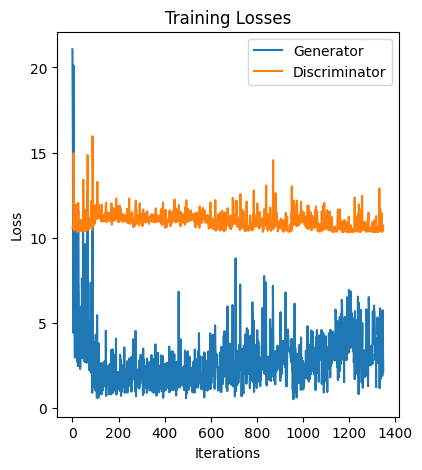

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(G_losses, label='Generator')
plt.plot(D_losses, label='Discriminator')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')

Text(0.5, 1.0, 'FID Score Over Time')

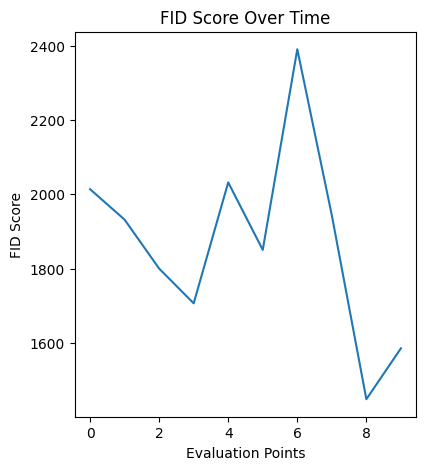

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 2)
plt.plot(fid_scores)
plt.xlabel('Evaluation Points')
plt.ylabel('FID Score')
plt.title('FID Score Over Time')

Text(0.5, 1.0, 'SSIM Score Over Time')

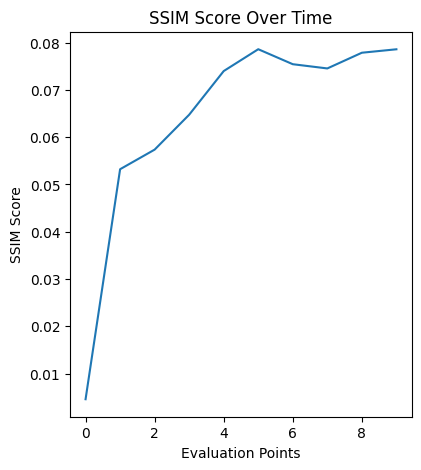

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 3)
plt.plot(ssim_scores)
plt.xlabel('Evaluation Points')
plt.ylabel('SSIM Score')
plt.title('SSIM Score Over Time')

Generate Final Samples

In [ ]:
print("Generating final samples...")
with torch.no_grad():
    final_samples = netG(torch.randn(64, nz, 1, 1, device=device)).detach().cpu()

utils.save_image(final_samples, os.path.join(save_dir, 'final_samples.png'), normalize=True, nrow=8)

Generating final samples...


In [ ]:
# Save final models
torch.save(netG.state_dict(), os.path.join(save_dir, "final_generator.pth"))
torch.save(netD.state_dict(), os.path.join(save_dir, "final_discriminator.pth"))

In [ ]:
print("Training completed!")
print(f"Best FID Score: {min(fid_scores) if fid_scores else 'N/A'}")
print(f"Best SSIM Score: {max(ssim_scores) if ssim_scores else 'N/A'}")

Training completed!
Best FID Score: 1448.8568875439687
Best SSIM Score: 0.07859549242787076
